# Oxford Weather Dataset

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
if not (base_dir / "data/jena_climate_2009_2016.csv").exists():
    download_test_jena_data(base_dir / "data")

In [4]:
ds = load_test_jena_data_as_dataset(base_dir / "data")
ds.time

<xarray.DataArray 'time' (time: 1000)>
array(['2009-01-01T00:10:00.000000000', '2009-01-01T00:20:00.000000000',
       '2009-01-01T00:30:00.000000000', ..., '2009-01-07T22:20:00.000000000',
       '2009-01-07T22:30:00.000000000', '2009-01-07T22:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01T00:10:00 ... 2009-01-07T22:40:00

# Load in config file

In [5]:
cfg = Config(base_dir / "tests/testconfigs/jena.yml")
cfg._cfg["n_epochs"] = 10
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 1
cfg._cfg["seq_length"] = 48
cfg

{'autoregressive': True,
 'batch_size': 30,
 'data_dir': PosixPath('data'),
 'experiment_name': 'jena',
 'hidden_size': 64,
 'horizon': 1,
 'input_variables': ['p (mbar)', 'rh (%)'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 10,
 'num_workers': 4,
 'optimizer': 'Adam',
 'pixel_dims': ['pixel'],
 'run_dir': None,
 'seed': 1234,
 'seq_length': 48,
 'target_variable': 'T (degC)',
 'test_end_date': Timestamp('2009-07-06 00:00:00'),
 'test_start_date': Timestamp('2009-01-06 00:00:00'),
 'train_end_date': Timestamp('2009-01-05 00:00:00'),
 'train_start_date': Timestamp('2009-01-02 00:00:00'),
 'validation_end_date': Timestamp('2009-01-02 00:00:00'),
 'validation_start_date': Timestamp('2009-01-01 00:00:00')}

# Create trainer

In [6]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 527.39it/s]


In [7]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.40
Valid Loss: 0.51


Training Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.16
Valid Loss: 0.19


Training Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.09
Valid Loss: 0.06


Training Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.25
Valid Loss: 0.05


Training Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.09
Valid Loss: 0.07


Training Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.11
Valid Loss: 0.26


Training Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.08
Valid Loss: 0.07


Training Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.12
Valid Loss: 0.32


Training Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.06
Valid Loss: 0.06


Validation Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 55.93it/s]

Train Loss: 0.07
Valid Loss: 0.15


# Check losses of trained model

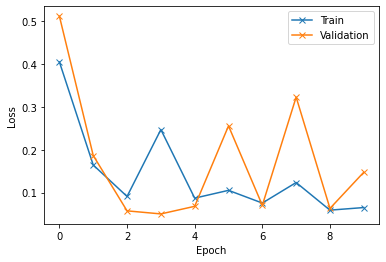

In [8]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Run Evaluation

In [9]:
# ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date))
print(ds.time.min())
print(ds.time.max())

<xarray.DataArray 'time' ()>
array('2009-01-01T00:10:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2009-01-07T22:40:00.000000000', dtype='datetime64[ns]')


In [10]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 389.70it/s]


Test set Forward Pass: 100%|██████████| 8/8 [00:00<00:00, 74.83it/s]


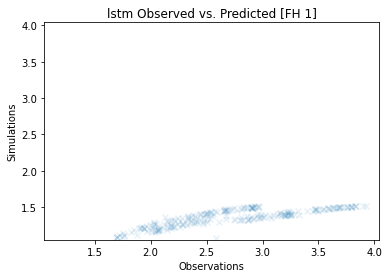

In [11]:
tester.run_test()

# The output forecasts! 

In [12]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
ds = xr.open_dataset(xr_path).isel(horizon=0, pixel=0).drop(["horizon", "pixel"])
ds

<xarray.Dataset>
Dimensions:  (time: 232)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-06T08:10:09.931821056 ... 2009-01-...
Data variables:
    sim      (time) float32 ...
    obs      (time) float32 ...

- there seems to be a normalisation problem
- Missing the scale of the observations

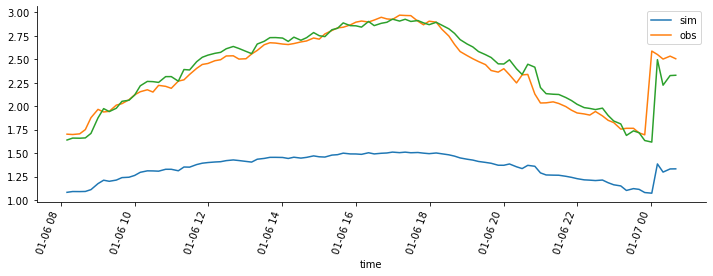

In [34]:
# .sel(time=slice("2015-01-01", "2015-02-01"))
f, ax = plt.subplots(figsize=(12, 4))
ds.isel(time=slice(0, 100)).to_dataframe().plot(ax=ax)

# artificial improvement
((ds.isel(time=slice(0, 100)).to_dataframe()["sim"] ** 2.2) + 0.45).plot(ax=ax)

plt.xticks(rotation=70);
sns.despine()